In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [56]:
class Data(object):
    def __init__(self, fname):
        self.f = h5py.File(fname, "r")
        
    @property
    def sequences(self):
        return self.f["sequences"].value
    
    @property
    def phi2(self):
        return self.f["phi-2"].value

    @property
    def phi3(self):
        return self.f["phi-3"].value
    
    @property
    def phifull(self):
        return self.f["phi-full"].value
    
    @property
    def rsquared2(self):
        return self.f["rsquared-2"].value

    @property
    def rsquared3(self):
        return self.f["rsquared-3"].value

In [57]:
d = Data("scripts/lattice-8site-full.hdf5")

In [62]:
with open("phifull.csv", "w") as f:
    for i in range(100):
        wildtype = d.sequences[i][0].astype(str)
        mutant = d.sequences[i][1].astype(str) 
        vals = ",".join([str(val) for val in d.phifull[i]])
        f.write(",".join([wildtype,mutant,vals]) + "\n")

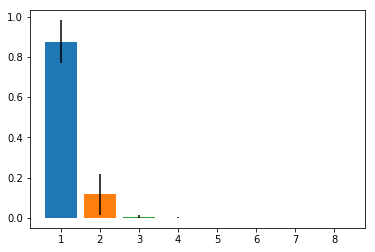

In [58]:
m = np.mean(d.phifull, axis=0)
s = np.std(d.phifull, axis=0)
for i in range(0,8):
    plt.bar(i+1, m[i], yerr=s[i], color="C"+str(i))

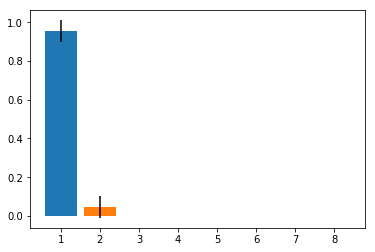

In [4]:
m = np.mean(d.phi2, axis=0)
s = np.std(d.phi2, axis=0)
for i in range(0,8):
    plt.bar(i+1, m[i], yerr=s[i], color="C"+str(i))

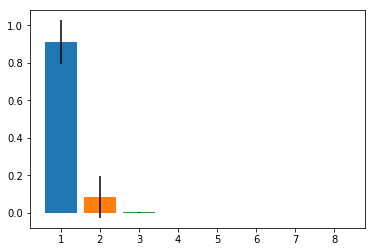

In [10]:
m = np.mean(d.phi3, axis=0)
s = np.std(d.phi3, axis=0)
for i in range(0,8):
    plt.bar(i+1, m[i], yerr=s[i], color="C"+str(i))

In [37]:
def stats(vals):
    vals.sort(axis=0)
    mean = np.mean(vals, axis=0)
    #print(vals)
    lower = vals[15]
    upper = vals[85]
    return mean, mean - lower, upper - mean

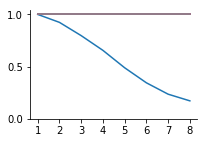

In [52]:
fig, ax = plt.subplots(figsize=(3,2))
for i in range(8):
    m, lower, upper = stats(d.rsquared2[:, i, :])
    #m = np.mean(d.rsquared2[:, i, :], axis=0)
    #s = np.std(d.rsquared2[:, i, :], axis=0)
    ax.plot(range(1,9), m)#, yerr=[lower,upper])

ticks = ax.set_xticks(range(1,9))
ticks = ax.set_yticks([0,.5,1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

fig.savefig("2-state-predictions.pdf", format="pdf")

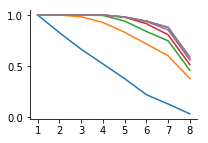

In [53]:
fig, ax = plt.subplots(figsize=(3,2))

for i in range(8):
    m, lower, upper = stats(d.rsquared3[:, i, :])
    ax.plot(range(1,9), m)#, yerr=[lower, upper])
    
ticks = ax.set_xticks(range(1,9))
ticks = ax.set_yticks([0,.5,1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

fig.savefig("3-state-predictions.pdf", format="pdf")

# FOR TESTING

In [48]:
import numpy as np
import h5py
import networkx as nx

from epistasis.models.linear import EpistasisLinearRegression
from epistasis.simulate import LinearSimulation, NonlinearSimulation
from epistasis.stats import pearson
from epistasis.plot import coefs

from gpmap.evolve.models import fixation
from gpmap.graph.paths import path_probabilities, paths_and_probabilities

from latticeproteins.sequences import RandomSequence

from latticegpm import LatticeGenotypePhenotypeMap
from latticegpm.thermo import LatticeThermodynamics
from latticegpm.search import adaptive_walk, get_lowest_confs

In [44]:
def prob_walk_to_other_genotypes(local_model, subpaths):
    """Calculate the probability of walking to nodes away from ancestor.

    - Output is a list of lists of lists containing (model-order, probabilites).
    - output[0][0] is a list predicted probabilities using model 0 to genotypes
      1 mutation away.
    """
    # Quick check.
    if local_model.model_type != "local":
        raise Exception("Argument must be a local model.")

    def frac_folded(x):
        return 1 / (1 + np.exp(x))

    output = []
    for order in range(1, 9):
        # Build truncated simulation from local model coefs
        em = local_model.epistasis.get_orders(*list(range(order+1)))
        sim = NonlinearSimulation.from_coefs(
            local_model.gpm.wildtype,
            local_model.gpm.mutations,
            em.labels,
            em.values,
            function=frac_folded,
            model_type="local")
        mapping = sim.map("genotypes", "indices")
        source = mapping[wildtype]
        Gsim = sim.add_networkx()
        Gsim.add_evolutionary_model(fixation)

        # Probability of moves away.
        probs = []
        for n_mut, trajs in enumerate(subpaths):
            probs.append(path_probabilities(Gsim, trajs))
        output.append(probs)

    return output

def rsquared_between_paths(summary):
    """Compare truncated model trajectory predictions to the full order model.

    Summary is the output from `prob_walk_to_other_genotypes`
    """
    rsquareds = []
    actual = summary[-1]
    for i, trajs in enumerate(summary):
        results = []
        for n_muts, trunc_ in enumerate(summary[i]):
            real = np.array(actual[n_muts])
            trunc = np.array(trunc_)
            r2 = pearson(real, trunc)**2
            if np.isnan(r2):
                r2 = 0
            results.append(r2)
        rsquareds.append(results)
    return rsquareds

In [36]:
i = 1
wildtype = d.sequences[i][0].astype(str)
mutant = d.sequences[i][1].astype(str)

In [51]:
cs = get_lowest_confs(wildtype, 3, database="scripts/database")
wt = LatticeThermodynamics(wildtype, conf_list=cs[0:2], temperature=1)
mut = LatticeThermodynamics(mutant, conf_list=cs[0:2], temperature=1)

In [64]:
# Build a list of subpaths that we care about
gpm = LatticeGenotypePhenotypeMap.from_Lattice(wt, mut, target_conf=wt.conf_list[0])
G = gpm.add_networkx()
mapping = gpm.map("genotypes", "indices")
source = mapping[wildtype]
target = mapping[mutant]

subpaths = [[] for i in range(8)]
for g in gpm.genotypes[1:]:
    target = mapping[g]
    paths = list(nx.all_shortest_paths(G, source, target))
    binary = gpm.binary.genotypes[target]
    n = binary.count("1")-1
    subpaths[n] += (paths)

gpm.phenotype_type = "stabilities"
lmodel2 = EpistasisLinearRegression.from_gpm(gpm, order=8, model_type="local")
lmodel2.fit()
            
#gpm = LatticeGenotypePhenotypeMap.from_Lattice(wt, mut, temperature=1, target_conf=wt.conf_list[0])
gpm.phenotype_type = "stabilities"
gmodel2 = EpistasisLinearRegression.from_gpm(gpm, order=8, model_type="global")
gmodel2.fit()

/home/zsailer/virtual/py3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/home/zsailer/virtual/py3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


In [68]:
from epistasis.plot import coefs

(<matplotlib.figure.Figure at 0x7f163f4916a0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f163f060390>])

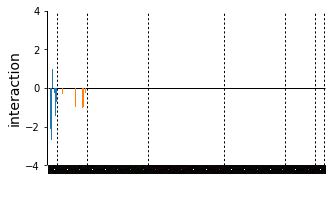

In [72]:
coefs(lmodel2.epistasis.values, lmodel2.epistasis.labels)

In [70]:
summary2 = prob_walk_to_other_genotypes(lmodel2, subpaths)

/home/zsailer/github/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


In [71]:
rsquared_between_paths(summary2)

/home/zsailer/github/epistasis/epistasis/stats.py:210: RuntimeWarning: invalid value encountered in double_scalars
  return numerator/denominator


[[1.0,
  0.97507486884340377,
  0.85363584003694271,
  0.56188723578282684,
  0.012750281959077363,
  2.0490984830149931e-05,
  0,
  0],
 [1.0,
  1.0,
  1.0000000000000004,
  1.0000000000000009,
  1.0000000000000009,
  0.99999999999992228,
  0.9999999999986855,
  0.72617316489542993],
 [1.0,
  1.0,
  1.0000000000000004,
  0.99999999999999956,
  1.0000000000000053,
  0.99999999999993272,
  0.99999999999867861,
  0.85551595117716983],
 [1.0,
  1.0,
  1.0000000000000004,
  1.0000000000000004,
  1.0000000000000009,
  0.99999999999994826,
  0.99999999999909339,
  0.76616513764299032],
 [1.0,
  1.0,
  1.0000000000000004,
  1.0000000000000004,
  1.0,
  0.99999999999996247,
  0.99999999999925704,
  0.78054905153196497],
 [1.0,
  1.0,
  1.0000000000000004,
  1.0000000000000004,
  1.0,
  1.0,
  0.99999999999923661,
  0.82793928493611479],
 [1.0,
  1.0,
  1.0000000000000004,
  1.0000000000000004,
  1.0,
  1.0,
  1.0,
  0.86839035089239069],
 [1.0, 1.0, 1.0000000000000004, 1.0000000000000004, 1.0,